In [ ]:
import os
import pandas as pd
import nltk
import string
import contractions
from collections import defaultdict
from profanity import profanity
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

lemmatizer = nltk.WordNetLemmatizer()

{'hadn', 's', "couldn't", 'ma', 'most', 'isn', "wasn't", 'yourselves', 'about', 'theirs', 'the', 'shan', 'below', 'some', 'won', "you'd", 'your', 'each', 'should', 'ain', 'after', 'a', "wouldn't", 'you', 'from', 'only', 'don', 'itself', 'i', 'do', "hasn't", 'above', "aren't", 'to', 'be', 'themselves', 'is', 'very', 'were', 'such', 'being', "haven't", "you're", 'does', 'we', 'am', 'then', 'yourself', 'those', 'me', 'why', 'didn', 'its', 'was', 'our', 'over', "isn't", 'can', 'herself', 'aren', "that'll", "it's", 'm', 'up', 'haven', 'her', "you'll", 'by', 'so', 'wasn', 'same', 'did', 'out', "mightn't", "shouldn't", 'hasn', "shan't", 'where', 'needn', 'hers', 'them', 'these', "needn't", 'too', 'myself', 'again', 'few', "should've", 'shouldn', 'having', 'they', 'or', 'mightn', 'of', 'against', 'through', 'which', 'doing', 'and', 'if', 'off', 'than', 'on', "weren't", 'under', 'has', 'both', 'himself', 'not', 'will', 'any', 'other', 'when', 'mustn', 'been', 'are', "doesn't", 're', 'weren', 'f

In [3]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "Midnights", "folklore", "evermore", "The Tortured Poets Department"]

In [4]:
df = pd.read_csv('songs.csv')


In [57]:
in_album = df[df['Album'].isin(albums)]
df = in_album

titles_not_included = ["Jump Then Fall (Taylor's Version)", "Untouchable (Taylor's Version)", "Come In With The Rain (Taylor's Version)",
                       "Superstar (Taylor's Version)", "The Other Side of the Door (Taylor's Version)", "Today Was a Fairytale (Taylor's Version)",
                       "If This Was a Movie (Taylor's Version)", "The Moment I Knew (Taylor's Version)", "Come Back...Be Here (Taylor's Version)", 
                       "Girl At Home (Taylor's Version)", "Ronan (Taylor's Version)", "Wonderland (Taylor's Version)", "You Are In Love (Taylor's Version)",
                        "New Romantics (Taylor's Version)", "Sweeter Than Fiction (Taylor's Version)",  "All Of The Girls You Loved Before", "the lakes",
                        "right where you left me", "it's time to go", "Hits Different", "The Great War", "Bigger Than The Whole Sky", "High Infidelity", 
                        "Would've, Could've, Should've","Dear Reader", "Paris", "Glitch", "The Black Dog", "imgonnagetyouback", "The Albatross", 
                        "Chloe or Sam or Sophia or Marcus", "How Did It End?", "So High School", "I Hate It Here", "thanK you aIMee", "I Look in People's Windows",
                        "The Prophecy", "Cassandra", "Peter", "The Bolter", "Robin", "The Manuscript"]

df = df[~df['Title'].str.contains(r"from the vault|From the Vault|From The Vault|Remix", case=False, na=False)]
df = df[~df['Title'].isin(titles_not_included)]

In [ ]:
total_words_per_song = defaultdict(lambda : defaultdict(str))
unique_words_per_song = defaultdict(lambda : defaultdict(str))
word_length_per_song = defaultdict(lambda : defaultdict(int))
pronoun_use_per_song = defaultdict(lambda : defaultdict( lambda : defaultdict(int)))
profanity_per_album = defaultdict(int)
num_songs = defaultdict(int)



within_description = 0
for lyric in df['Lyrics']:

    song_title = df.loc[df['Lyrics'] == lyric, 'Title']
    song_title = song_title.iloc[0]

    album_name = df.loc[df['Lyrics'] == lyric, 'Album']
    album_name = album_name.iloc[0]
    num_songs[album_name] += 1

    word_list=lyric.split()
    word_data = ""
    for word in word_list:
        if "[" or "]" in word:
            if "[" in word and not("]" in word):
                within_description = 1
            elif "]" in word and not("[" in word):
                within_description = 0
            elif "[" in word and "]" in word:
                within_description = 0
            if "(" in word and not(")" in word):
                within_description = 1
            elif ")" in word and not("(" in word):
                within_description = 0
            elif "(" in word and ")" in word:
                within_description = 0
        if not("]" in word or "[" in word or "(" in word or ")" in word) and not(within_description):
            for contraction in contractions.contractions_dict.keys():
                if contraction.lower() in word.lower():
                    word = contractions.fix(word)
            word_data += word + " "

    music_stop_words = ["''", "'", "``", "'s", "'d", "'m", "oh", "hey", "mm", "oh-oh", "oh-oh-oh", "mmm", "ooh", "ooh-oh", "mm-mm", "la", "ah-ah", "ha", 
                        "ha-ah", "di", "da", "da-da", "uh-huh", "ra-di-di-di-di-di-di-di-di-di-da-da", "ah-ah-ah-ah-ah", "ah-ah-ah", "ah-ah-ah-ah",
                       "ah-ah-ah-ah-ah-ah",  "ah","eh",  "uh-uh","ooh-woo-ooh-ooh-ooh",  "ooh-ooh-ooh-ooh", "ooh-ooh-ooh", "la-la-la", "la-la-la-la", 
                       "woah", "eeh-eeh-eeh", "ooh-ah", "ooh-ayy" , "oh-woah", "ha-ah-ah", "ha-ah-ah-ah", "oh-oh-ah", "mmm-hmm", "uh-huh-huh",
                       "da-da-da-da", "oh-oh-oh-oh", "na-na-na" , "na-na", "..."]
    
    first_person_singular = ["i", "me", "my", "mine", "myself"]
    first_person_plural = ["us", "we", "our", "ours", "ourselves"]
    second_person = ["you", "your", "yours", "yourself", "yourselves"]
    
    nltk_tokens = nltk.word_tokenize(text=word_data, language='english', preserve_line=True)

    new_tokens = []
    token_set = set()
    token_length = 0
    for token in nltk_tokens:
        if token not in music_stop_words and token not in string.punctuation:
            token = token.lower()
            if token in {"i-i-i-i", "i-i", "i-i-i"}:
                token = "i"
            if token in {"me-e-e", "me-e-e-e-e", "me-e-e-e-e-e"}:
                token = "me"
            if token == "mind-ind-ind":
                token = "mind"
            if token == "drowning-ing-ing-ing-ing":
                token = "drowning"
            if token == "see-e-e-e-e-e":
                token = "see"
            if token == "vendetta-ta":
                token = "vendetta"
            if token == "i-island":
                token = "island"
            if token == "trip-trippin":
                token = "trippin"
            if token == "skip-skippin":
                token = "skippin"
            if token == "d-y-i-n-g":
                token = "dying"
            new_tokens.append(token)
            # total_words_per_song[album_name][song_title] += 1
            # if token not in token_set:
            #     unique_words_per_song[album_name][song_title] += 1
            token_set.add(token)

            if token in first_person_singular:
                pronoun_use_per_song[album_name][song_title]['FPSP'] += 1
            elif token in first_person_plural:
                pronoun_use_per_song[album_name][song_title]['FPPP'] += 1
            elif token in second_person:
                pronoun_use_per_song[album_name][song_title]['SPP'] += 1
            
            token_length += len(token)
    
    total_words_per_song[album_name][song_title] = new_tokens
    unique_words_per_song[album_name][song_title] = token_set
    
    token_length /= len(new_tokens)
    word_length_per_song[album_name][song_title] = token_length

    new_tokens = " ".join(new_tokens)
    profanity_bool = profanity.contains_profanity(new_tokens)
    if profanity_bool:
        profanity_per_album[album_name] += 1
    
    df.loc[df['Title'] == song_title, 'Lyrics'] = new_tokens

for song in profanity_per_album:
    profanity_per_album[song] /= num_songs[song]
        



In [97]:
print(word_length_per_song)
print(profanity_per_album)
print(pronoun_use_per_song)
print(unique_words_per_song)
print(total_words_per_song)
print(num_songs)

defaultdict(<function <lambda> at 0x303cd3d80>, {'Taylor Swift': defaultdict(<class 'int'>, {'Tim McGraw': 3.727272727272727, 'Picture to Burn': 3.849056603773585, 'Teardrops On My Guitar': 3.443396226415094, 'A Place In This World': 3.14, 'Cold as You': 3.7301587301587302, 'The Outside': 3.403292181069959, 'Tied Together with a Smile': 3.684014869888476, 'Stay Beautiful': 3.9054545454545453, "Should've Said No": 3.7540983606557377, "Mary's Song (Oh My My My)": 3.630630630630631, 'Our Song': 3.618798955613577, "I'm Only Me When I'm With You": 3.3323529411764707, 'Invisible': 3.706766917293233, 'A Perfectly Good Heart': 3.721774193548387}), "Fearless (Taylor's Version)": defaultdict(<class 'int'>, {"Fearless (Taylor's Version)": 3.6545454545454548, "Fifteen (Taylor's Version)": 3.8043478260869565, "Love Story (Taylor's Version)": 3.5714285714285716, "Hey Stephen (Taylor's Version)": 3.451990632318501, "White Horse (Taylor's Version)": 3.629283489096573, "You Belong With Me (Taylor's Ver

In [72]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

shortenings = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "Rep", "Lover", 
          "Folklore", "Evermore", "Midnights", "TTPD"]

color = ['#008080', '#D7B575', '#774F8F', '#921D16', '#5585AC', '#202020', '#df6cab', '#05472A', '#B05925', '#4B5A86', '#BDAE95']

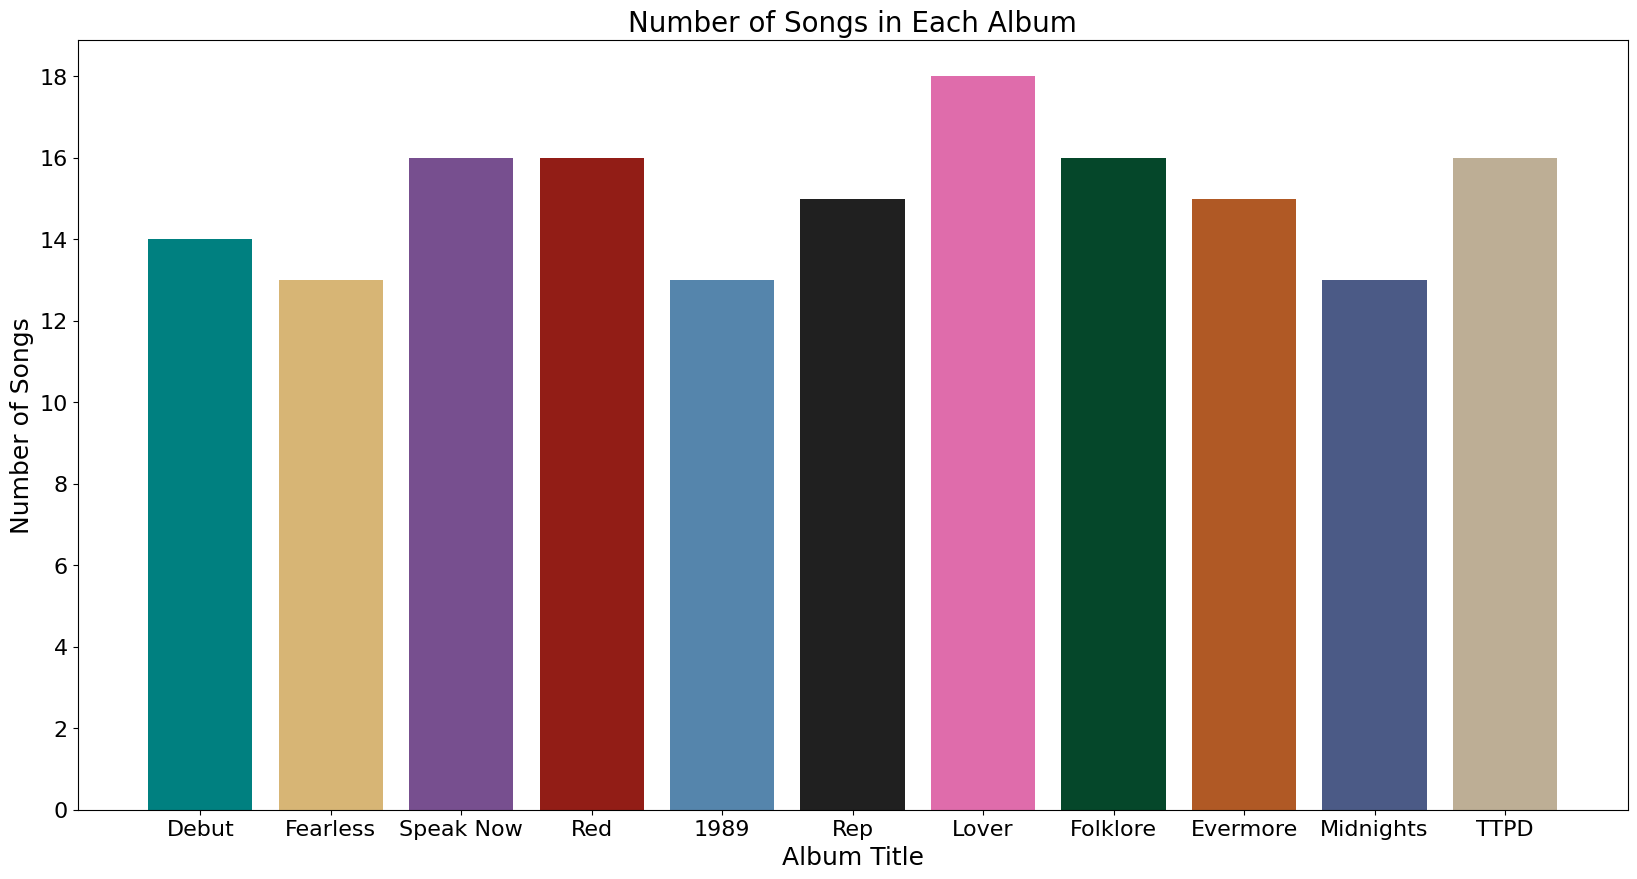

In [79]:
plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], num_songs[album], color=color[i])

plt.title("Number of Songs in Each Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Songs", fontsize = "18")

plt.yticks(np.arange(0, 20, 2))

plt.show()

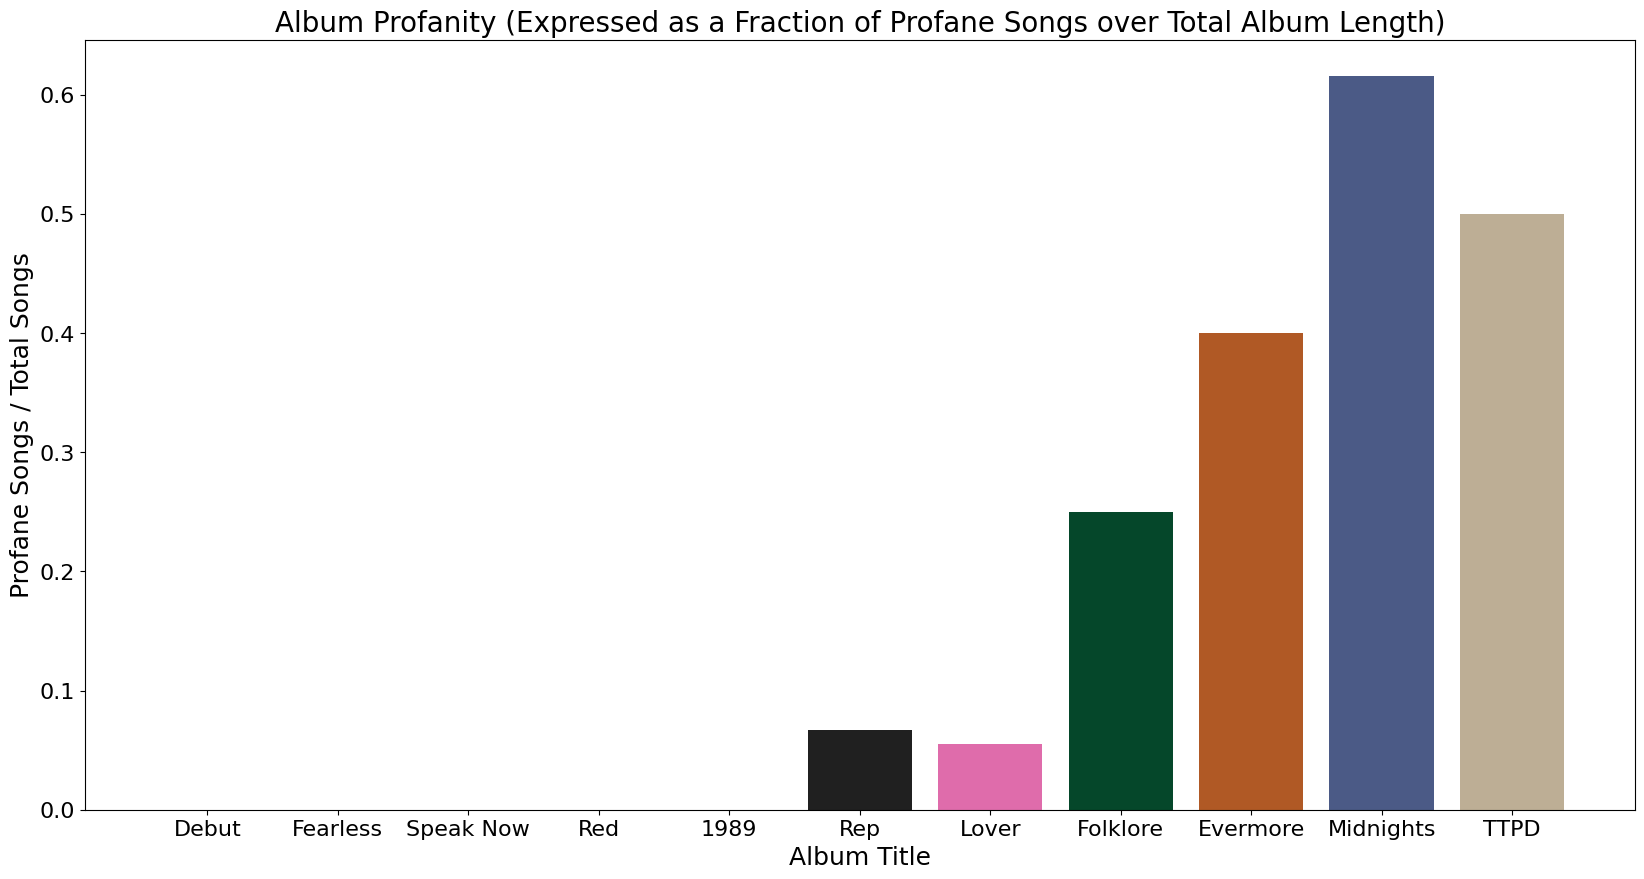

In [75]:
plt.figure(figsize=(20, 10))

for i, album in enumerate(albums):
    plt.bar(shortenings[i], profanity_per_album[album], color=color[i])

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Album Profanity (Expressed as a Fraction of Profane Songs over Total Album Length)", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Profane Songs / Total Songs", fontsize='18')
plt.show()

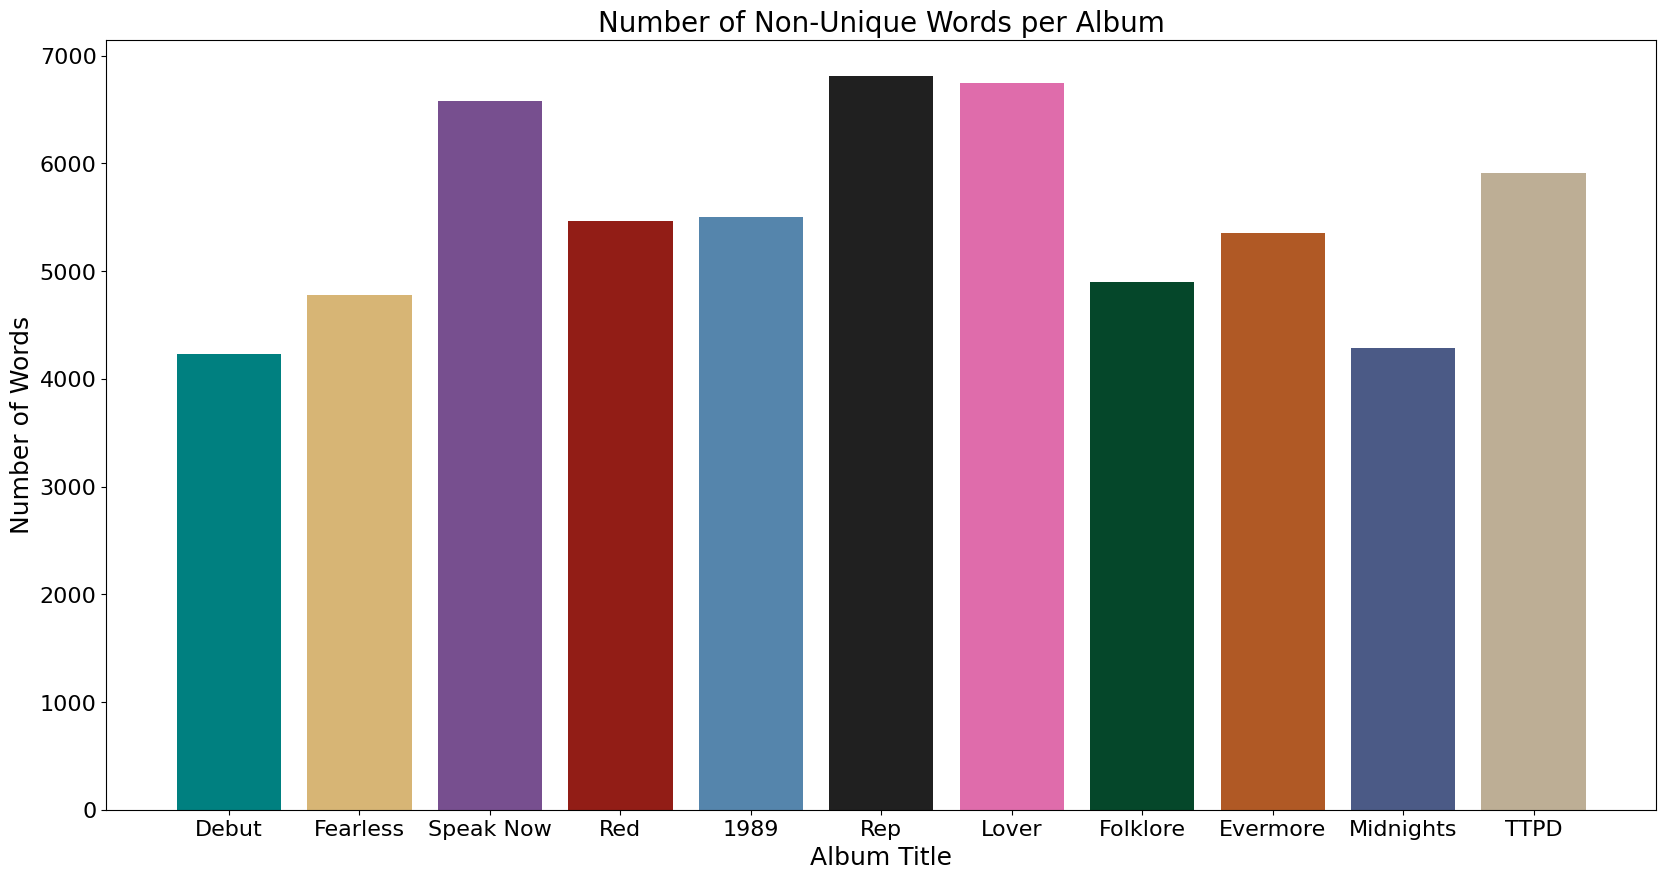

In [90]:
total_words_per_album = {}
for key in total_words_per_song:
    list_data = []
    for song in total_words_per_song[key]:
        list_data += total_words_per_song[key][song]
    total_words_per_album[key] = len(list_data)

plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], total_words_per_album[album], color=color[i])

plt.title("Number of Non-Unique Words per Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Words", fontsize = "18")

plt.show()

Text(0, 0.5, 'Number of Words')

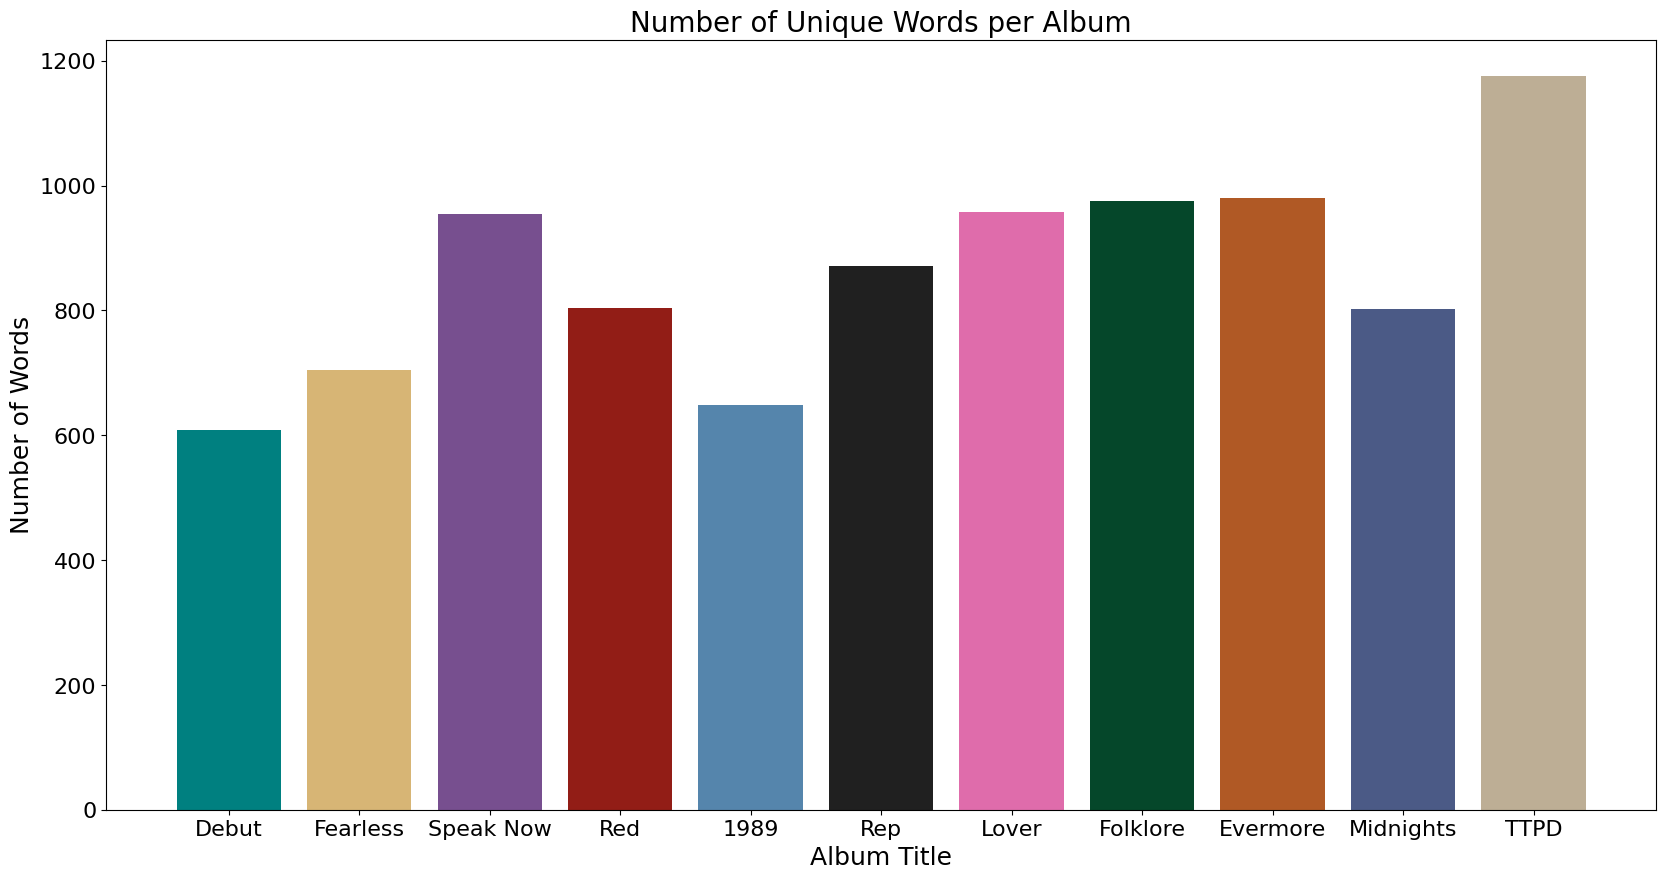

In [93]:
unique_words_per_album = {}
for key in unique_words_per_song:
    set_data = set()
    for song in unique_words_per_song[key]:
        set_data = set_data | unique_words_per_song[key][song]
    unique_words_per_album[key] = len(set_data)

plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], unique_words_per_album[album], color=color[i])

plt.title("Number of Unique Words per Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Words", fontsize = "18")

Text(0, 0.5, 'Number of Words')

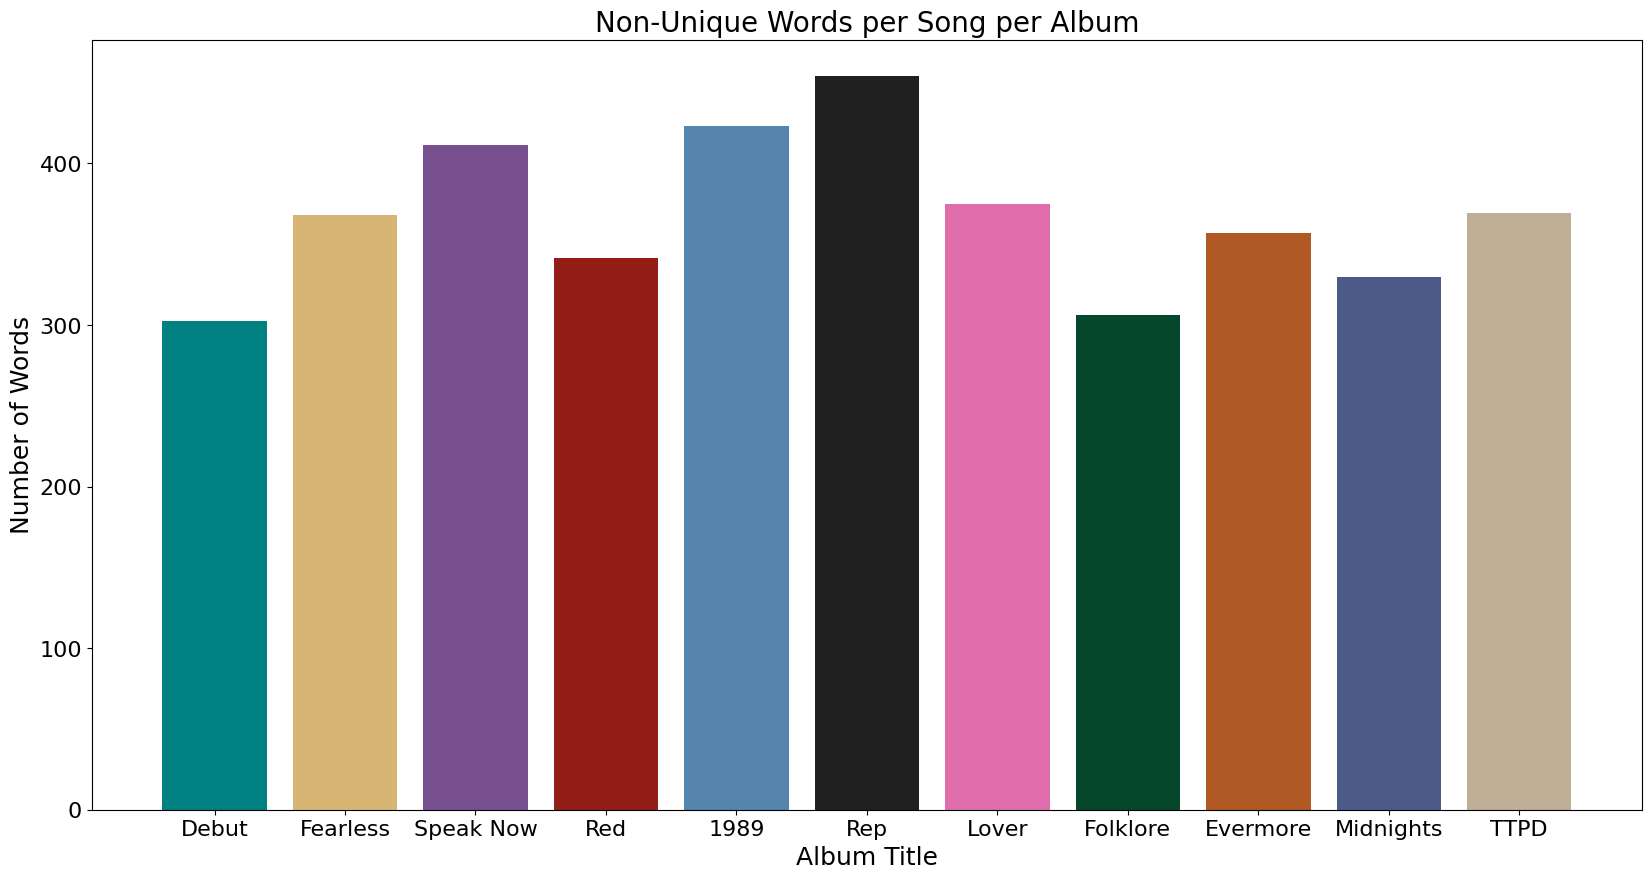

In [94]:
avg_total_words_per_song_per_album = {}

for key in total_words_per_album:
    avg_total_words_per_song_per_album[key] = total_words_per_album[key]/num_songs[key]

plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], avg_total_words_per_song_per_album[album], color=color[i])

plt.title("Non-Unique Words per Song per Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Words", fontsize = "18")


Text(0, 0.5, 'Number of Words')

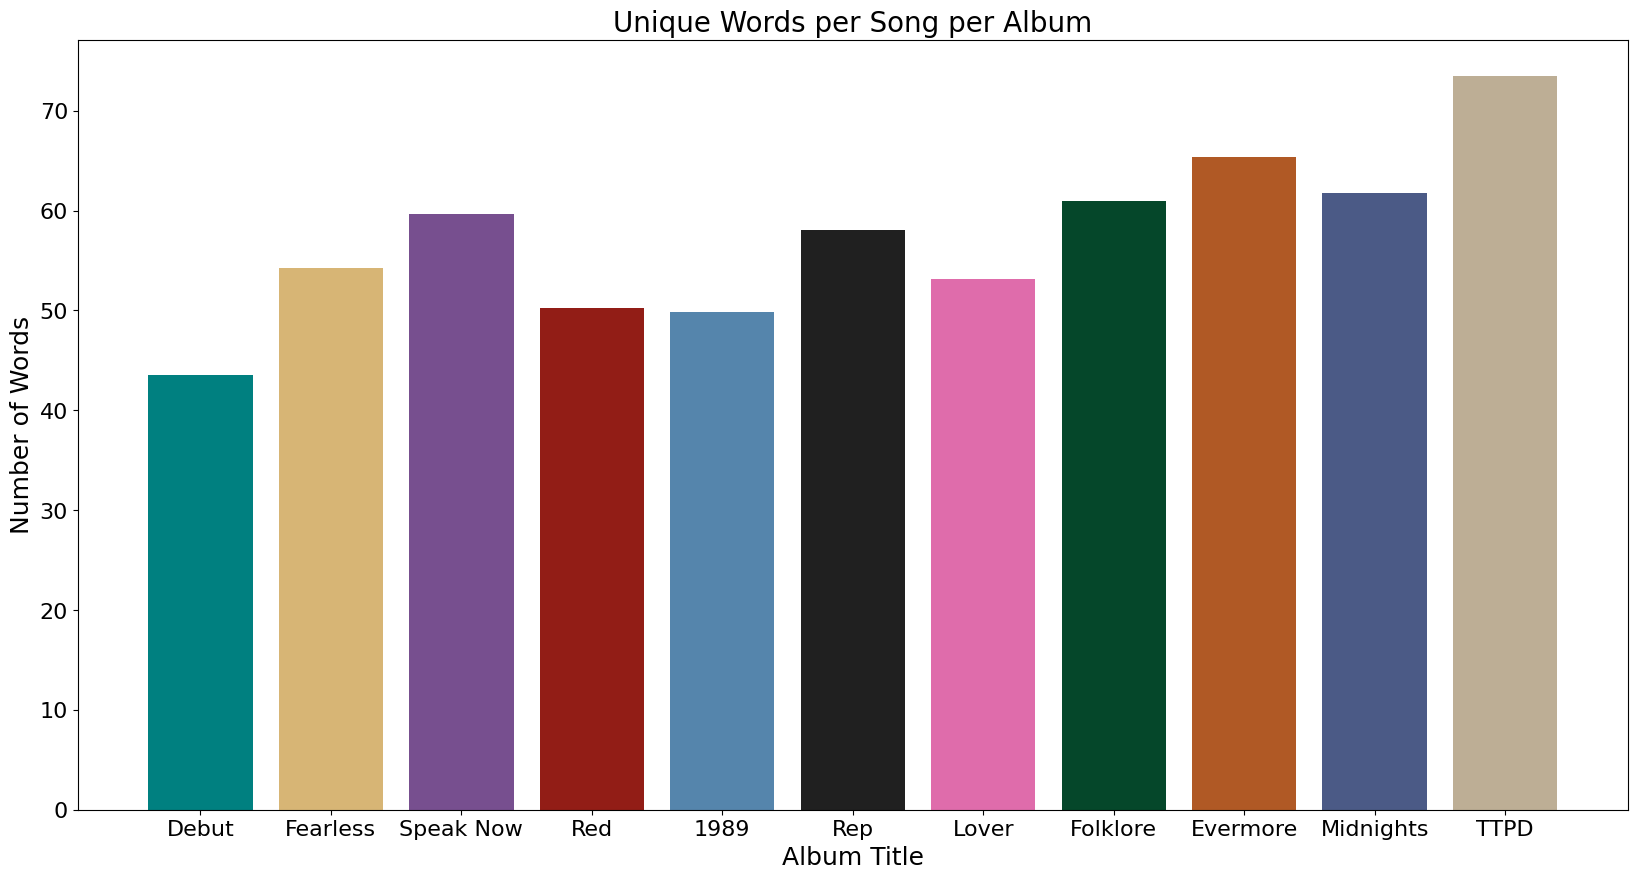

In [95]:
avg_unique_words_per_song_per_album = {}

for key in unique_words_per_album:
    avg_unique_words_per_song_per_album[key] = unique_words_per_album[key]/num_songs[key]

plt.figure(figsize=(20, 10))

plt.tick_params(axis="both", which='major', labelsize="16")

for i, album in enumerate(albums):
    plt.bar(shortenings[i], avg_unique_words_per_song_per_album[album], color=color[i])

plt.title("Unique Words per Song per Album", fontsize = "20")
plt.xlabel("Album Title", fontsize = "18")
plt.ylabel("Number of Words", fontsize = "18")

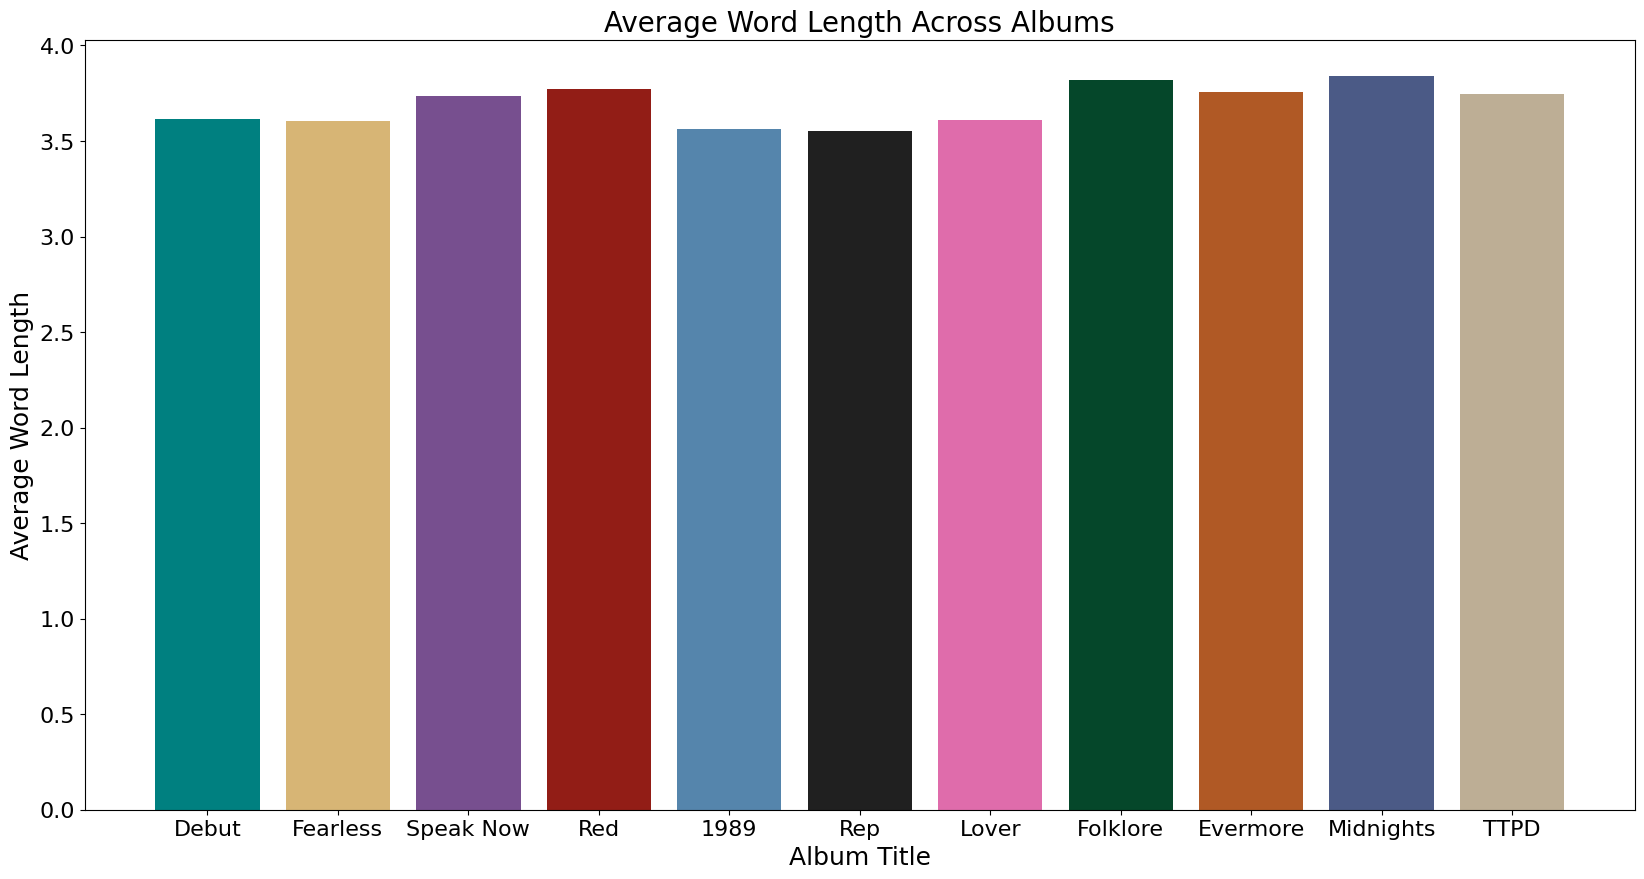

In [98]:
average_word_length_across_albums = {}

for key in word_length_per_song:
        total = 0
        for song in word_length_per_song[key]:
            total += word_length_per_song[key][song]
        average_word_length_across_albums[key] = total / num_songs[key]


plt.figure(figsize=(20, 10))

for i, album in enumerate(albums):
    plt.bar(shortenings[i], average_word_length_across_albums[album], color=color[i])

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Average Word Length Across Albums", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Average Word Length", fontsize='18')
plt.show()

In [99]:
print(pronoun_use_per_song)

defaultdict(<function <lambda> at 0x305174680>, {'Taylor Swift': defaultdict(<function <lambda>.<locals>.<lambda> at 0x30596f1a0>, {'Tim McGraw': defaultdict(<class 'int'>, {'FPSP': 32, 'FPPP': 3, 'SPP': 29}), 'Picture to Burn': defaultdict(<class 'int'>, {'FPSP': 31, 'SPP': 25}), 'Teardrops On My Guitar': defaultdict(<class 'int'>, {'FPSP': 35, 'FPPP': 1}), 'A Place In This World': defaultdict(<class 'int'>, {'FPSP': 39, 'SPP': 1}), 'Cold as You': defaultdict(<class 'int'>, {'SPP': 22, 'FPSP': 15}), 'The Outside': defaultdict(<class 'int'>, {'FPSP': 25, 'SPP': 8}), 'Tied Together with a Smile': defaultdict(<class 'int'>, {'SPP': 31, 'FPSP': 2}), 'Stay Beautiful': defaultdict(<class 'int'>, {'FPSP': 15, 'SPP': 26}), "Should've Said No": defaultdict(<class 'int'>, {'FPPP': 2, 'FPSP': 23, 'SPP': 42}), "Mary's Song (Oh My My My)": defaultdict(<class 'int'>, {'FPSP': 40, 'SPP': 19, 'FPPP': 19}), 'Our Song': defaultdict(<class 'int'>, {'FPSP': 27, 'FPPP': 12, 'SPP': 8}), "I'm Only Me When I

In [110]:
total_fpsp = []
total_fppp = []
total_spp = []

for key in pronoun_use_per_song:
    fpsp = 0
    fppp = 0
    spp = 0
    for song in pronoun_use_per_song[key]:
        for pronoun in pronoun_use_per_song[key][song]:
            if pronoun == 'FPSP':
                fpsp += pronoun_use_per_song[key][song][pronoun]
            elif pronoun == 'FPPP':
                fppp += pronoun_use_per_song[key][song][pronoun]
            elif pronoun == 'SPP':
                spp += pronoun_use_per_song[key][song][pronoun]

    total_fpsp.append(fpsp)
    total_fppp.append(fppp)
    total_spp.append(spp)

print(total_fpsp)
print(total_fppp)
print(total_spp)

[348, 409, 507, 450, 414, 683, 770, 471, 484, 381, 570]
[47, 52, 76, 100, 163, 89, 90, 27, 36, 23, 56]
[286, 366, 476, 399, 304, 400, 353, 335, 319, 199, 296]


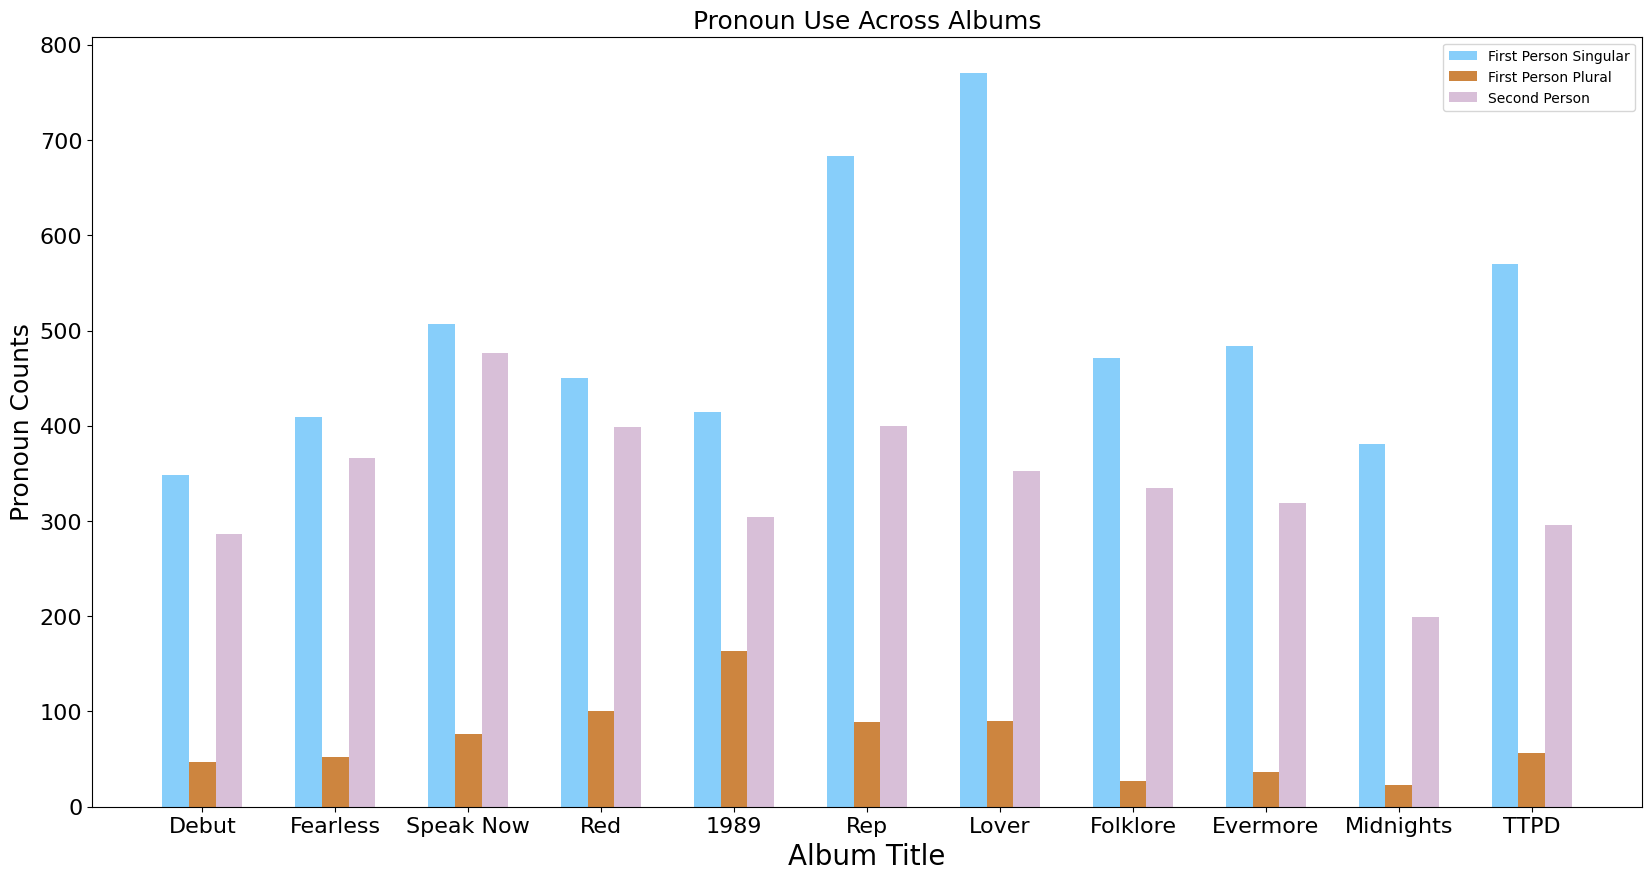

In [119]:
# Set the width of each bar
bar_width = 0.2

# Create an array of x positions for the bars
x = np.arange(len(shortenings))

# Create the figure and axes
fig = plt.subplots(figsize=(20,10))

br1 = np.arange(len(total_fpsp)) 
br2 = [x + bar_width for x in br1] 
br3 = [x + bar_width for x in br2]

# Plot the first set of bars
plt.bar(br1, total_fpsp, label='First Person Singular', width=bar_width, color='lightskyblue')

# Plot the second set of bars
plt.bar(br2, total_fppp, label='First Person Plural', width=bar_width, color='peru')

# Plot the second set of bars
plt.bar(br3, total_spp, label='Second Person', width=bar_width, color='thistle')

# Set the x-axis labels
plt.xticks(x)
plt.tick_params(axis="both", which='major', labelsize="16")

plt.xticks([r + bar_width for r in range(len(total_fppp))], 
        shortenings)

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Album Title', fontsize = '20')
plt.ylabel('Pronoun Counts', fontsize = '18')
plt.title('Pronoun Use Across Albums', fontsize = '18')

# Show the plot
plt.show()

In [121]:
exclude = ['was', 'us']

for lyric in df['Lyrics']:

    song_title = df.loc[df['Lyrics'] == lyric, 'Title']
    song_title = song_title.iloc[0]

    album_name = df.loc[df['Lyrics'] == lyric, 'Album']
    album_name = album_name.iloc[0]
    num_songs[album_name] += 1

    nltk_tokens=lyric.split()

    nltk_tokens = [token for token in nltk_tokens if token not in stop_words]
    nltk_tokens = [token if token != exclude else lemmatizer.lemmatize(token) for token in nltk_tokens] 

    file_path = 'songs_excl_ftv/'+ album_name
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    song = os.path.join(file_path, f"{song_title}.txt")
    with open(song, "w", encoding="utf-8") as f:
        literal = "\n".join(nltk_tokens)
        f.write(literal)